In [43]:
import matplotlib.pyplot as plt

from superfv import EulerSolver, plot_1d_slice, OutputLoader
from superfv.initial_conditions import interacting_blast_wave_1d

In [44]:
T = 0.038
N = 400
Nref = 10000
overwrite = False

base_path = "../../out/interacting-blast-wave/"

In [45]:
common = dict(PAD={"rho": (0, None), "P": (0, None)})
musclhancock = dict(p=1, MUSCL=True, **common)
apriori = dict(ZS=True, lazy_primitives="adaptive", **common)
aposteriori = dict(
    MOOD=True,
    face_fallback=False,
    lazy_primitives="full",
    MUSCL_limiter="moncen",
    **common,
)
aposteriori1 = dict(cascade="muscl", max_MOOD_iters=1, **aposteriori)
aposteriori2 = dict(cascade="muscl1", max_MOOD_iters=2, **aposteriori)
aposteriori3 = dict(cascade="muscl1", max_MOOD_iters=3, **aposteriori)

configs = {
    "ref": dict(MUSCL_limiter="moncen", **musclhancock),
    "MUSCL-Hancock": dict(MUSCL_limiter="moncen", **musclhancock),
    "ZS3": dict(p=3, **apriori),
    "ZS7": dict(p=7, **apriori),
    "MM3/1rev/no_NAD": dict(p=3, NAD=False, SED=False, **aposteriori1),
    "MM7/1rev/no_NAD": dict(p=7, NAD=False, SED=False, **aposteriori1),
    "MM3/1rev/rtol_1e1": dict(p=3, NAD_rtol=1e1, **aposteriori1),
    "MM7/1rev/rtol_1e1": dict(p=7, NAD_rtol=1e1, **aposteriori1),
    "MM3/1rev/rtol_1e0": dict(p=3, NAD_rtol=1e0, **aposteriori1),
    "MM7/1rev/rtol_1e0": dict(p=7, NAD_rtol=1e0, **aposteriori1),
    "MM3/1rev/rtol_5e-1": dict(p=3, NAD_rtol=5e-1, **aposteriori1),
    "MM7/1rev/rtol_5e-1": dict(p=7, NAD_rtol=5e-1, **aposteriori1),
    "MM3/1rev/rtol_1e-1": dict(p=3, NAD_rtol=1e-1, **aposteriori1),
    "MM7/1rev/rtol_1e-1": dict(p=7, NAD_rtol=1e-1, **aposteriori1),
    "MM3/1rev/rtol_5e-2": dict(p=3, NAD_rtol=5e-2, **aposteriori1),
    "MM7/1rev/rtol_5e-2": dict(p=7, NAD_rtol=5e-2, **aposteriori1),
    "MM3/1rev/rtol_1e-2": dict(p=3, NAD_rtol=1e-2, **aposteriori1),
    "MM7/1rev/rtol_1e-2": dict(p=7, NAD_rtol=1e-2, **aposteriori1),
    "MM3/1rev/rtol_1e-3": dict(p=3, NAD_rtol=1e-3, **aposteriori1),
    "MM7/1rev/rtol_1e-3": dict(p=7, NAD_rtol=1e-3, **aposteriori1),
    "MM3/1rev/rtol_1e-5": dict(p=3, NAD_rtol=1e-5, **aposteriori1),
    "MM7/1rev/rtol_1e-5": dict(p=7, NAD_rtol=1e-5, **aposteriori1),
    "MM3/1rev/rtol_0": dict(p=3, NAD_rtol=0, **aposteriori1),
    "MM7/1rev/rtol_0": dict(p=7, NAD_rtol=0, **aposteriori1),
    "MM3/2revs/rtol_1e0": dict(p=3, NAD_rtol=1e0, **aposteriori2),
    "MM7/2revs/rtol_1e0": dict(p=7, NAD_rtol=1e0, **aposteriori2),
    "MM3/2revs/rtol_1e-1": dict(p=3, NAD_rtol=1e-1, **aposteriori2),
    "MM7/2revs/rtol_1e-1": dict(p=7, NAD_rtol=1e-1, **aposteriori2),
    "MM3/2revs/rtol_1e-2": dict(p=3, NAD_rtol=1e-2, **aposteriori2),
    "MM7/2revs/rtol_1e-2": dict(p=7, NAD_rtol=1e-2, **aposteriori2),
    "MM3/3revs/no_NAD": dict(p=3, NAD=False, SED=False, **aposteriori3),
    "MM7/3revs/no_NAD": dict(p=7, NAD=False, SED=False, **aposteriori3),
    "MM3/3revs/rtol_1e1": dict(p=3, NAD_rtol=1e1, **aposteriori3),
    "MM7/3revs/rtol_1e1": dict(p=7, NAD_rtol=1e1, **aposteriori3),
    "MM3/3revs/rtol_1e0": dict(p=3, NAD_rtol=1e0, **aposteriori3),
    "MM7/3revs/rtol_1e0": dict(p=7, NAD_rtol=1e0, **aposteriori3),
    "MM3/3revs/rtol_1e-1": dict(p=3, NAD_rtol=1e-1, **aposteriori3),
    "MM7/3revs/rtol_1e-1": dict(p=7, NAD_rtol=1e-1, **aposteriori3),
    "MM3/3revs/rtol_1e-2": dict(p=3, NAD_rtol=1e-2, **aposteriori3),
    "MM7/3revs/rtol_1e-2": dict(p=7, NAD_rtol=1e-2, **aposteriori3),
}

In [46]:
sims = {}
for name, config in configs.items():
    sim_path = f"{base_path}{name}"

    if not overwrite:
        try:
            sim = OutputLoader(sim_path)
            sims[name] = sim
            continue
        except FileNotFoundError:
            pass

    print(f"Running simulation: {name}")
    sim = EulerSolver(
        ic=interacting_blast_wave_1d,
        bcx="reflective",
        nx=Nref if name == "ref" else N,
        **config,
    )

    try:
        sim.run(
            T,
            q_max=2,
            muscl_hancock=config.get("MUSCL", False),
            path=sim_path,
            allow_overshoot=True,
            overwrite=overwrite,
        )
    except Exception as e:
        print(f"Simulation {name} failed: {e}")
        continue

    sims[name] = sim

Successfully read simulation output from "../../out/interacting-blast-wave/ref"
Successfully read simulation output from "../../out/interacting-blast-wave/MUSCL-Hancock"
Successfully read simulation output from "../../out/interacting-blast-wave/ZS3"
Successfully read simulation output from "../../out/interacting-blast-wave/ZS7"
Successfully read simulation output from "../../out/interacting-blast-wave/MM3/1rev/no_NAD"
Successfully read simulation output from "../../out/interacting-blast-wave/MM7/1rev/no_NAD"
Successfully read simulation output from "../../out/interacting-blast-wave/MM3/1rev/rtol_1e1"
Successfully read simulation output from "../../out/interacting-blast-wave/MM7/1rev/rtol_1e1"
Successfully read simulation output from "../../out/interacting-blast-wave/MM3/1rev/rtol_1e0"
Successfully read simulation output from "../../out/interacting-blast-wave/MM7/1rev/rtol_1e0"
Successfully read simulation output from "../../out/interacting-blast-wave/MM3/1rev/rtol_5e-1"
Successfully re

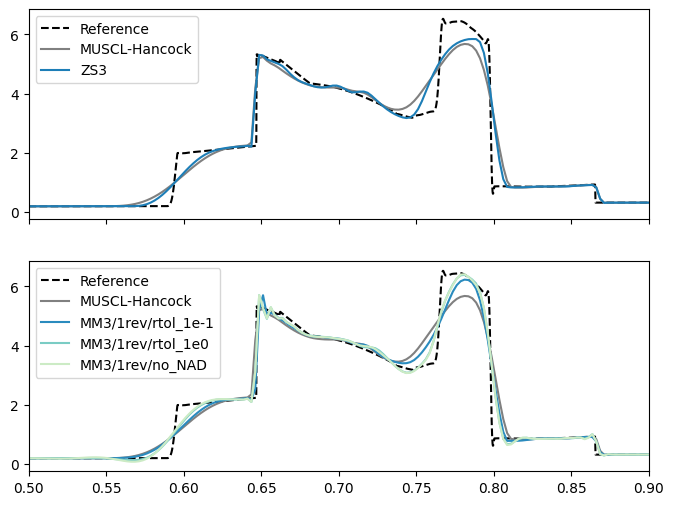

In [47]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(8, 6))
axs[0].set_xlim(0.5, 0.9)

cmap = plt.get_cmap("GnBu")

plot_1d_slice(sims["ref"], axs[0], "rho", color="k", linestyle="--", label="Reference")
plot_1d_slice(sims["MUSCL-Hancock"], axs[0], "rho", color="grey", label="MUSCL-Hancock")
plot_1d_slice(sims["ZS3"], axs[0], "rho", color=cmap(0.8), label="ZS3")

plot_1d_slice(sims["ref"], axs[1], "rho", color="k", linestyle="--", label="Reference")
plot_1d_slice(sims["MUSCL-Hancock"], axs[1], "rho", color="grey", label="MUSCL-Hancock")
plot_1d_slice(
    sims["MM3/1rev/rtol_1e-1"],
    axs[1],
    "rho",
    color=cmap(0.75),
    label="MM3/1rev/rtol_1e-1",
)
plot_1d_slice(
    sims["MM3/1rev/rtol_1e0"], axs[1], "rho", color=cmap(0.5), label="MM3/1rev/rtol_1e0"
)
plot_1d_slice(
    sims["MM3/1rev/no_NAD"], axs[1], "rho", color=cmap(0.25), label="MM3/1rev/no_NAD"
)

axs[0].legend()
axs[1].legend()

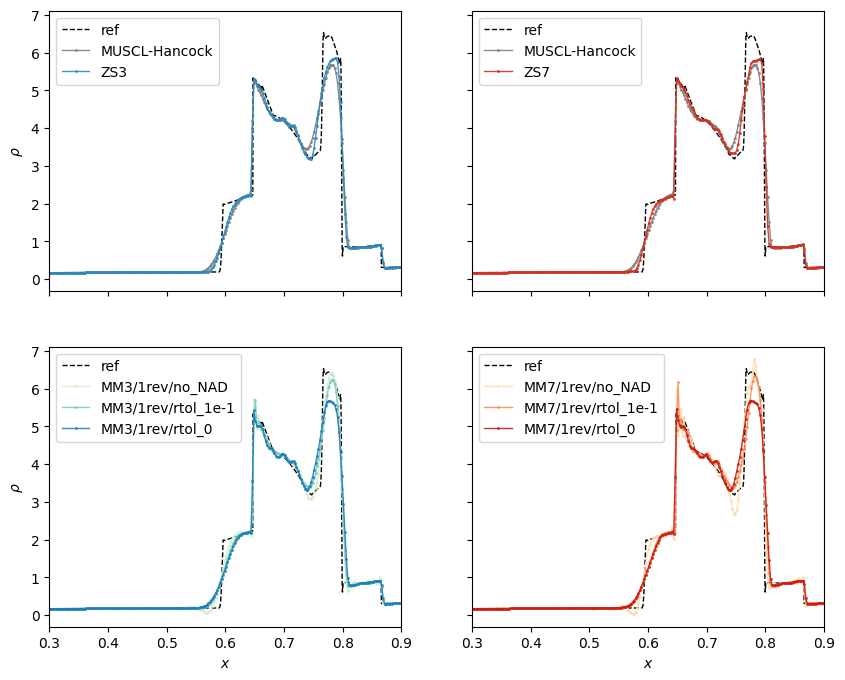

In [48]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 8))
axs[1, 0].set_xlabel(r"$x$")
axs[1, 1].set_xlabel(r"$x$")
axs[0, 0].set_ylabel(r"$\rho$")
axs[1, 0].set_ylabel(r"$\rho$")
axs[0, 0].set_xlim(0.3, 0.9)

cmap1 = plt.get_cmap("GnBu")
cmap2 = plt.get_cmap("OrRd")


def plot(name, ax, v, style=dict()):
    plot_1d_slice(
        sims[name],
        ax,
        v,
        label=name,
        linewidth=1,
        markersize=1,
        marker="none" if name == "ref" else "o",
        mfc="none",
        alpha=1 if name == "ref" else 0.9,
        **style,
    )


plot("ref", axs[0, 0], "rho", dict(color="k", linestyle="--"))
plot("MUSCL-Hancock", axs[0, 0], "rho", dict(color="grey"))
plot("ZS3", axs[0, 0], "rho", dict(color=cmap1(0.75)))

plot("ref", axs[0, 1], "rho", dict(color="k", linestyle="--"))
plot("MUSCL-Hancock", axs[0, 1], "rho", dict(color="grey"))
plot("ZS7", axs[0, 1], "rho", dict(color=cmap2(0.75)))

plot("ref", axs[1, 0], "rho", dict(color="k", linestyle="--"))
plot("MM3/1rev/no_NAD", axs[1, 0], "rho", dict(color=cmap1(0.2)))
plot("MM3/1rev/rtol_1e-1", axs[1, 0], "rho", dict(color=cmap1(0.5)))
plot("MM3/1rev/rtol_0", axs[1, 0], "rho", dict(color=cmap1(0.8)))

plot("ref", axs[1, 1], "rho", dict(color="k", linestyle="--"))
plot("MM7/1rev/no_NAD", axs[1, 1], "rho", dict(color=cmap2(0.2)))
plot("MM7/1rev/rtol_1e-1", axs[1, 1], "rho", dict(color=cmap2(0.5)))
plot("MM7/1rev/rtol_0", axs[1, 1], "rho", dict(color=cmap2(0.8)))

axs[0, 0].legend(loc="upper left")
axs[0, 1].legend(loc="upper left")
axs[1, 0].legend(loc="upper left")
axs[1, 1].legend(loc="upper left")

In [49]:
fig.savefig("interacting-blast-wave.pdf")